In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

In [3]:
trip_data_path = (r"C:\Users\kriti\kriti python\df_trips_202401.csv")
df = pd.read_csv(trip_data_path)

In [4]:
df['START_TIME'] = pd.to_datetime(df['START_TIME'], errors='coerce')
print("Earliest Date:", df['START_TIME'].min())
print("Latest Date:", df['START_TIME'].max())


Earliest Date: 2024-01-01 06:22:31
Latest Date: 2024-01-31 21:59:53


In [5]:
# Convert START_TIME to datetime if it's not already
df["START_TIME"] = pd.to_datetime(df["START_TIME"])

# Filter rows where START_TIME is a Wednesday (weekday = 2)
wed_df = df[df["START_TIME"].dt.weekday == 2].copy()

# Just double-check the shape and some dates
print("Filtered rows (Wednesday):", len(wed_df))
print("Date range in Wednesday data:", wed_df["START_TIME"].min(), "to", wed_df["START_TIME"].max())


Filtered rows (Wednesday): 3578
Date range in Wednesday data: 2024-01-03 06:06:26 to 2024-01-31 21:59:53


In [8]:
unique_wed_dates = sorted(wed_df['START_TIME'].dt.date.unique())
print("All Wednesday dates in data:")
for d in unique_wed_dates:
    print(d)


All Wednesday dates in data:
2024-01-03
2024-01-10
2024-01-17
2024-01-24
2024-01-31


In [10]:
# Step: Filter for January 10, 2024
selected_wed_date = pd.to_datetime("2024-01-10")
wed_single_day_df = wed_df[wed_df["START_TIME"].dt.date == selected_wed_date.date()].copy()

# Confirm the number of trips on that day
print("Trips on Jan 10, 2024:", len(wed_single_day_df))
wed_single_day_df.head(2)


Trips on Jan 10, 2024: 857


,PROVIDER_ID,PROVIDER_NAME,DEVICE_ID,VEHICLE_ID,VEHICLE_TYPE,PROPULSION_TYPE,TRIP_ID,TRIP_DURATION,TRIP_DISTANCE,ROUTE,...,START_TIME_RAW,END_TIME_RAW,PUBLICATION_TIME_RAW,PARKING_VERIFICATION_URL,STANDARD_COST,ACTUAL_COST,CURRENCY,GEOM_POINTS,ID,RUN_DATE
12026,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,0699df57-36cb-4127-9b16-bf38664b0309,EIMAB,scooter,electric,a2d25c70-5ab8-4fb2-b95c-9a09b5e63d2c,264,901,"{""type"":""FeatureCollection"",""features"":[{""type...",...,1704895182000,1704895446504,NaN,NaN,NaN,NaN,NaN,"{\n ""geometries"": [\n {\n ""coordinate...",3481099,NaN
12027,2411d395-04f2-47c9-ab66-d09e9e3c3251,Bird,44befcbc-1f86-483c-a4db-29ed8e691cde,3Y8R4,scooter,electric,dbb16bd0-4bb4-4994-a365-3956d044d151,227,796,"{""type"":""FeatureCollection"",""features"":[{""type...",...,1704895280704,1704895508235,NaN,NaN,NaN,NaN,NaN,"{\n ""geometries"": [\n {\n ""coordinate...",3481100,NaN


In [15]:
# Step: Convert meters to miles
wed_single_day_df["distance_miles"] = wed_single_day_df["TRIP_DISTANCE"] * 0.000621371

# Step: Define distance-based trip classes
def assign_trip_class(dist):
    if dist < 0.5:
        return 0
    elif 0.5 <= dist < 1:
        return 1
    elif 1 <= dist <= 2:
        return 2
    else:
        return 3

wed_single_day_df["trip_class"] = wed_single_day_df["distance_miles"].apply(assign_trip_class)

# Check the class distribution
wed_single_day_df["trip_class"].value_counts().sort_index()


0    306
1    333
2    173
3     45
Name: trip_class, dtype: int64

In [16]:
# Step: Calculate average values per class
summary_df = wed_single_day_df.groupby("trip_class").agg(
    count=("trip_class", "size"),
    avg_distance_mile=("distance_miles", "mean"),
    avg_duration_min=("TRIP_DURATION", lambda x: x.mean() / 60),  # convert sec to min
    avg_speed_mph=("distance_miles", lambda d: d.sum() / (wed_single_day_df.loc[d.index, "TRIP_DURATION"].sum() / 3600))  # speed = total dist / total hours
).reset_index()

# Round values like in the slide
summary_df = summary_df.round({
    "avg_distance_mile": 2,
    "avg_duration_min": 2,
    "avg_speed_mph": 2
})

# Remove this line locally – it's only for ChatGPT display
# tools.display_dataframe_to_user(name="Trip Summary Table", dataframe=summary_df)

# Instead, just display it normally for now
summary_df


,trip_class,count,avg_distance_mile,avg_duration_min,avg_speed_mph
0,0,306,0.28,3.99,4.23
1,1,333,0.71,6.28,6.78
2,2,173,1.37,11.33,7.28
3,3,45,2.77,25.30,6.57


In [19]:
# Load LYNX Blue Line stations
stations_path = (r"C:\Users\kriti\LYNX_Blue_Line_Stations.geojson")
stations_gdf = gpd.read_file(stations_path)

# Load LYNX Blue Line route
route_path = (r"C:\Users\kriti\LYNX_Blue_Line_Route.geojson")
blue_line_route_gdf = gpd.read_file(route_path)

In [40]:
import json
from shapely.geometry import LineString
import geopandas as gpd

# Step 1: Filter Jan 10 data
jan10_df = wed_df[wed_df["START_TIME"].dt.date == pd.to_datetime("2024-01-10").date()].copy()

# Step 2: Convert meters to miles
jan10_df["distance_miles"] = jan10_df["TRIP_DISTANCE"] * 0.000621371

# Step 3: Assign trip class
def assign_trip_class(dist):
    if dist < 0.5:
        return 0
    elif 0.5 <= dist < 1:
        return 1
    elif 1 <= dist <= 2:
        return 2
    else:
        return 3

jan10_df["trip_class"] = jan10_df["distance_miles"].apply(assign_trip_class)

# Step 4: Convert ROUTE to LineString
def extract_linestring(route_str):
    try:
        route = json.loads(route_str)
        coords = [f["geometry"]["coordinates"] for f in route.get("features", []) if "geometry" in f]
        return LineString(coords) if len(coords) >= 2 else None
    except:
        return None

jan10_df["route_line"] = jan10_df["ROUTE"].apply(extract_linestring)
jan10_df = jan10_df[jan10_df["route_line"].notnull()].copy()

# Step 5: Convert to GeoDataFrame
gdf_routes_all = gpd.GeoDataFrame(jan10_df, geometry="route_line", crs="EPSG:4326")


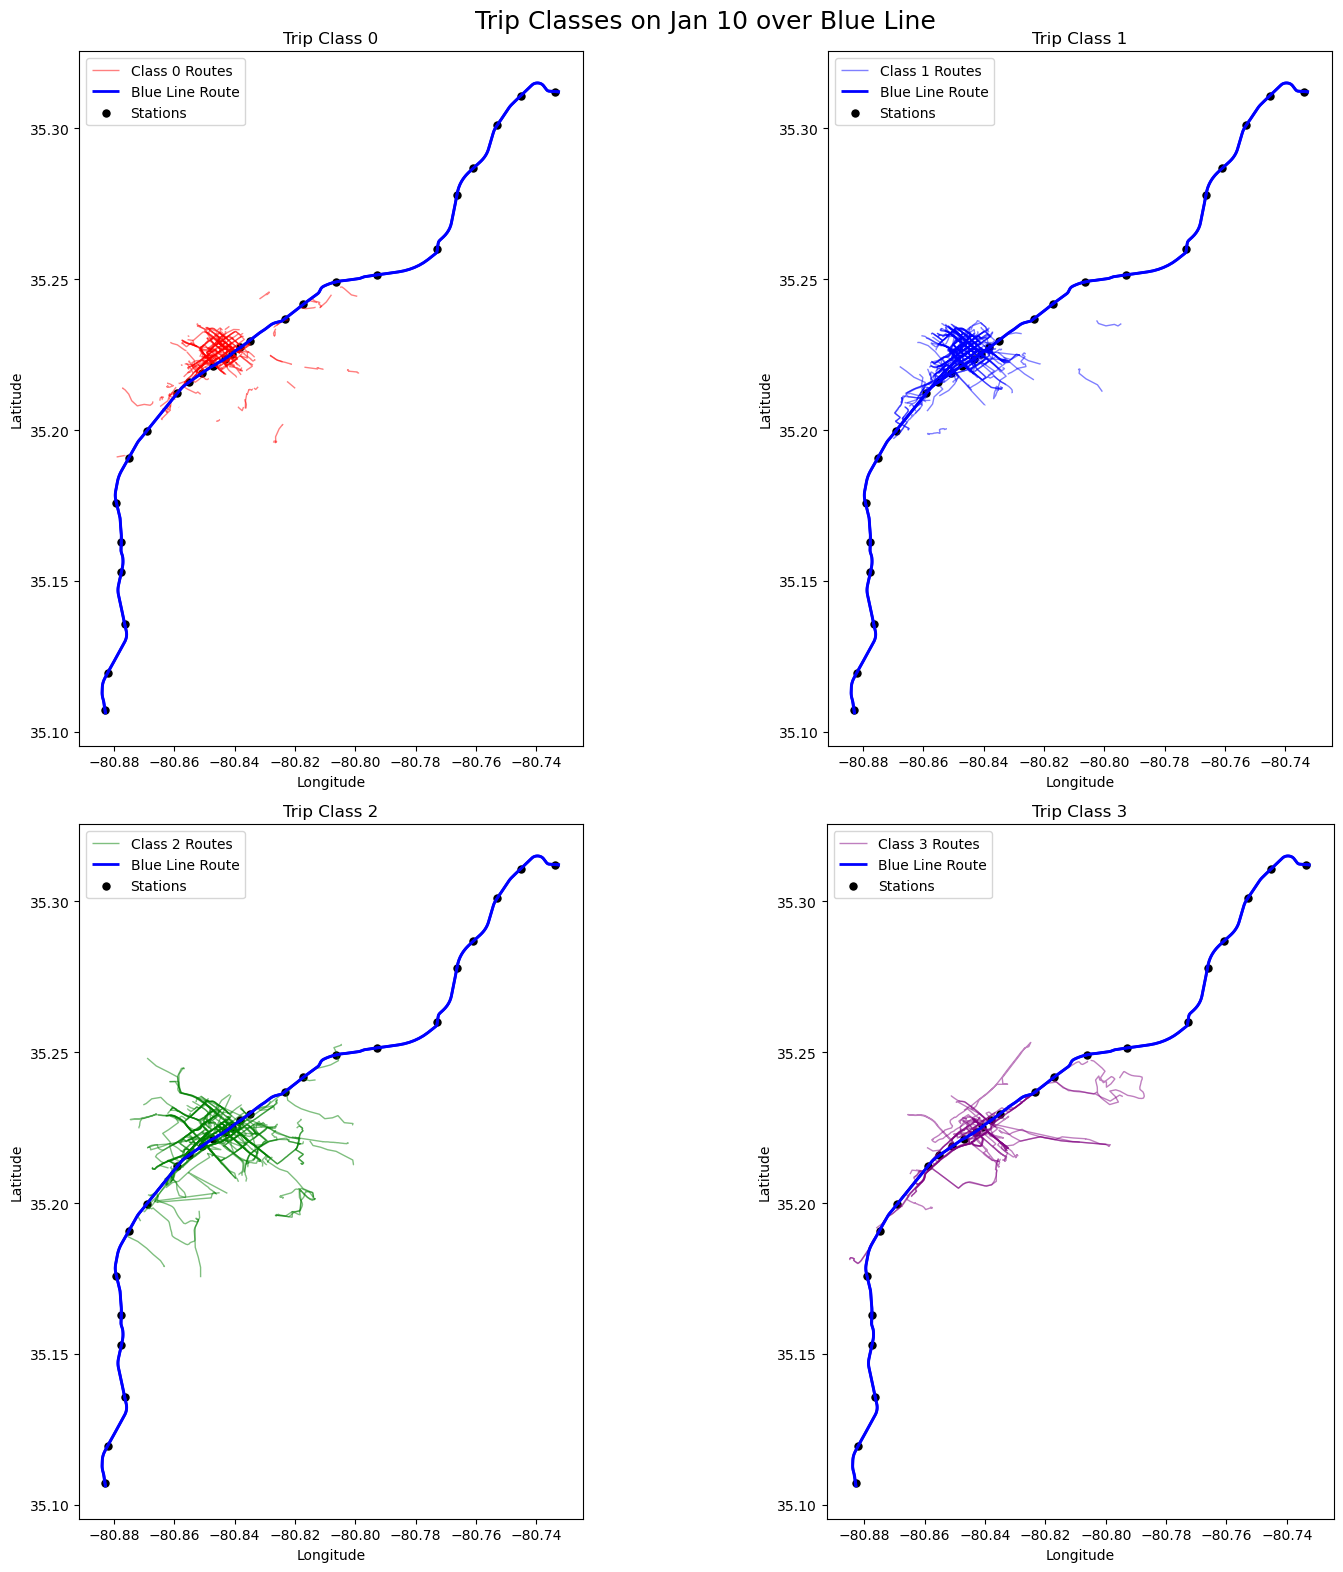

In [41]:
import matplotlib.pyplot as plt

# Color mapping per class
class_colors = {
    0: "red",
    1: "blue",
    2: "green",
    3: "purple"
}

# Plot each class in separate subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

for i, (trip_class, ax) in enumerate(zip(sorted(class_colors.keys()), axes.flatten())):
    class_gdf = gdf_routes_all[gdf_routes_all["trip_class"] == trip_class]

    class_gdf.plot(ax=ax, color=class_colors[trip_class], linewidth=1, alpha=0.5, label=f"Class {trip_class} Routes")
    blue_line_route_gdf.plot(ax=ax, color="blue", linewidth=2, label="Blue Line Route")
    stations_gdf.plot(ax=ax, color="black", edgecolor="white", markersize=50, label="Stations")

    ax.set_title(f"Trip Class {trip_class}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()
    ax.set_aspect("equal")

plt.suptitle("Trip Classes on Jan 10 over Blue Line", fontsize=18)
plt.tight_layout()
plt.show()
